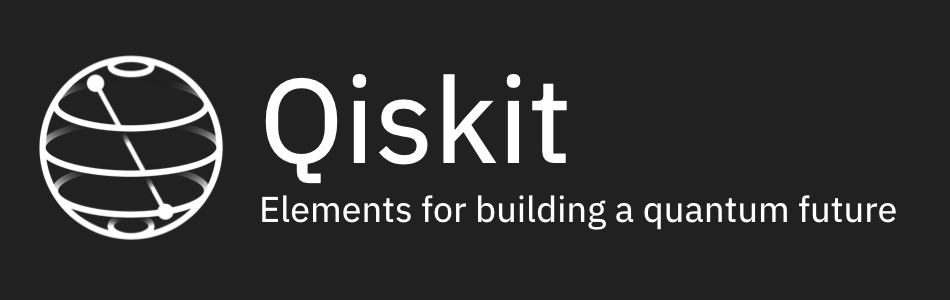

# _*Qiskit Chemistry, Programmatic Approach*_ 

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorial.

***
### Contributors
Richard Chen<sup>[1]</sup>, Antonio Mezzacapo<sup>[1]</sup>, Marco Pistoia<sup>[1]</sup>, Stephen Wood<sup>[1]</sup>
### Affiliation
- <sup>[1]</sup>IBMQ

### Introduction
This notebook illustrates how to use Qiskit Chemistry's programmatic APIs.

In this notebook, we decompose the computation of the ground state energy of a molecule into 4 steps:
  1. Define a molecule and get integrals from a computational chemistry driver (PySCF in this case)
  2. Construct a Fermionic Hamiltonian and map it onto a qubit Hamiltonian
  3. Instantiate and initialize dynamically-loaded algorithmic components, such as the quantum algorithm VQE, the optimizer and variational form it will use, and the initial_state to initialize the variational form
  4. Run the algorithm on a quantum backend and retrieve the results

In [1]:
# import common packages
import numpy as np

from qiskit import Aer

# lib from Qiskit Aqua
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.operators import Z2Symmetries
from qiskit.aqua.components.optimizers import COBYLA

# lib from Qiskit Aqua Chemistry
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

### Step 1: Define a molecule
Here, we use LiH in the sto3g basis with the PySCF driver as an example.
The `molecule` object records the information from the PySCF driver.

In [2]:
# using driver to get fermionic Hamiltonian
# PySCF example
driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 1.6', unit=UnitsType.ANGSTROM,
                     charge=0, spin=0, basis='sto3g')
molecule = driver.run()

### Step 2: Prepare qubit Hamiltonian
Here, we setup the **to-be-frozen** and **to-be-removed** orbitals to reduce the problem size when we map to the qubit Hamiltonian. Furthermore, we define the **mapping type** for the qubit Hamiltonian.
For the particular `parity` mapping, we can further reduce the problem size.

In [3]:
# please be aware that the idx here with respective to original idx
freeze_list = [0]
remove_list = [-3, -2] # negative number denotes the reverse order
map_type = 'parity'

h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# of electrons: {}".format(num_particles))
print("# of spin orbitals: {}".format(num_spin_orbitals))

HF energy: -8.854072040283647
# of electrons: 4
# of spin orbitals: 12


In [4]:
# prepare full idx of freeze_list and remove_list
# convert all negative idx to positive
remove_list = [x % molecule.num_orbitals for x in remove_list]
freeze_list = [x % molecule.num_orbitals for x in freeze_list]
# update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
remove_list = [x - len(freeze_list) for x in remove_list]
remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
freeze_list += [x + molecule.num_orbitals for x in freeze_list]

# prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
# and if PARITY mapping is selected, reduction qubits
energy_shift = 0.0
qubit_reduction = True if map_type == 'parity' else False

ferOp = FermionicOperator(h1=h1, h2=h2)
if len(freeze_list) > 0:
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
if len(remove_list) > 0:
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)

qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
qubitOp.chop(10**-10)

print(qubitOp.print_details())
print(qubitOp)

IIII	(-0.2076593350197074+0j)
IIIZ	(-0.09376337484626278+0j)
IIZX	(-0.0031775814548399956+0j)
IIIX	(0.0031775814548399956+0j)
IIXX	(-0.001251396599969751+0j)
IIYY	(0.001251396599969751+0j)
IIZZ	(-0.21162509515110128+0j)
IIXZ	(0.019200533863109957+0j)
IIXI	(0.019200533863109957+0j)
IIZI	(0.3581026994577025+0j)
IZII	(0.09376337484626282+0j)
ZXII	(0.0031775814548399973+0j)
IXII	(0.0031775814548399973+0j)
XXII	(-0.0012513965999697415+0j)
YYII	(0.0012513965999697415+0j)
ZZII	(-0.21162509515110128+0j)
XZII	(-0.019200533863109957+0j)
XIII	(0.019200533863109957+0j)
ZIII	(-0.3581026994577025+0j)
IZIZ	(-0.12182774215821467+0j)
IZZX	(0.012144897228064444+0j)
IZIX	(-0.012144897228064444+0j)
IZXX	(0.03169874598734439+0j)
IZYY	(-0.03169874598734439+0j)
IXIZ	(0.012144897228064444+0j)
ZXIZ	(0.012144897228064444+0j)
IXZX	(-0.0032659954996582014+0j)
ZXZX	(-0.0032659954996582014+0j)
IXIX	(0.0032659954996582014+0j)
ZXIX	(0.0032659954996582014+0j)
IXXX	(-0.008650156860609944+0j)
ZXXX	(-0.008650156860609944

We use the classical eigen decomposition to get the smallest eigenvalue as a reference.

In [5]:
# Using exact eigensolver to get the smallest eigenvalue
exact_eigensolver = ExactEigensolver(qubitOp, k=1)
ret = exact_eigensolver.run()
print('The computed energy is: {:.12f}'.format(ret['eigvals'][0].real))
print('The total ground state energy is: {:.12f}'.format(ret['eigvals'][0].real + energy_shift + nuclear_repulsion_energy))

The computed energy is: -1.077059745735
The total ground state energy is: -7.881072044031


### Step 3: Initiate and configure dynamically-loaded instances
To run VQE with the UCCSD variational form, we require
- VQE algorithm
- Classical Optimizer
- UCCSD variational form
- Prepare the initial state in the HartreeFock state

### [Optional] Setup token to run the experiment on a real device
If you would like to run the experiment on a real device, you need to setup your account first.

Note: If you did not store your token yet, use `IBMQ.save_account('MY_API_TOKEN')` to store it first.

In [6]:
# from qiskit import IBMQ
# provider = IBMQ.load_account()

In [7]:
backend = Aer.get_backend('statevector_simulator')

In [8]:
# setup COBYLA optimizer
max_eval = 200
cobyla = COBYLA(maxiter=max_eval)

# setup HartreeFock state
HF_state = HartreeFock(qubitOp.num_qubits, num_spin_orbitals, num_particles, map_type, 
                       qubit_reduction)

# setup UCCSD variational form
var_form = UCCSD(qubitOp.num_qubits, depth=1, 
                   num_orbitals=num_spin_orbitals, num_particles=num_particles, 
                   active_occupied=[0], active_unoccupied=[0, 1],
                   initial_state=HF_state, qubit_mapping=map_type, 
                   two_qubit_reduction=qubit_reduction, num_time_slices=1)

# setup VQE
vqe = VQE(qubitOp, var_form, cobyla)
quantum_instance = QuantumInstance(backend=backend)

### Step 4: Run algorithm and retrieve the results
The smallest eigenvalue is stored in the first entry of the `eigvals` key.

In [ ]:
results = vqe.run(quantum_instance)
print('The computed ground state energy is: {:.12f}'.format(results['eigvals'][0]))
print('The total ground state energy is: {:.12f}'.format(results['eigvals'][0] + energy_shift + nuclear_repulsion_energy))
print("Parameters: {}".format(results['opt_params']))

In [2]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright